# ADA, Homework: A Cheating Scandal at St. Bob University 🎓

---

By the end of this homework, we expect you to be able to:
- Load data and handle data using pandas;
- Navigate the documentation of Python packages by yourself;
- Filter and tidy up noisy real-world datasets;
- Aggregate your data in different (and hopefully helpful) ways;
- Create meaningful visualizations to analyze the data;
- Communicate your findings in a clear and concise manner

**Important Dates.**
- Homework release: Wed 05 Nov, 2025
- Homework due: Wed 26 Nov, 2025, 23:59 (CET)

**Some rules**
- You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, you may do so, but must justify your choice.
- Make sure you use the data folder provided in the repository in read-only mode. (Or alternatively, be sure you don’t change any of the files.)
- Be sure to provide a concise textual description of your thought process, the assumptions you made, the solution you implemented, and explanations for your answers. A notebook that only has code cells will not suffice. To avoid confusion: use short comments for longer code answers.
- For questions containing the /Discuss:/ prefix, answer not with code, but with a textual explanation (in markdown).
- Back up any hypotheses and claims with data, since this is an important aspect of the course.
- Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a single notebook (plus the required data files) in the master/main branch. If there are multiple notebooks present, we will not grade anything.
- We will not run your notebook for you! Rather, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. Thus, be sure to hand in a fully-run and evaluated notebook. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.
- In continuation to the previous point, interactive plots, such as those generated using the ‘plotly’ package, should be strictly avoided! Make sure to print results and/or dataframes that confirm you have properly addressed the task.  
- In this homework, we have a task that asks to do clustering. Clustering algorithms will be covered in the lecture on unsupervised learning on Nov 12, 2025.


**A Note on using Language Models (LMs)**
If you try hard enough, you will likely get away with cheating. Fortunately, our job is not to police, but rather to educate! So, please consider the following:

Presumably, you are taking this course to learn something! LMs are not always right (they often fail in silly ways). This course should prepare you to detect when they are wrong!
Some of the TAs on this course literally published many works on detecting machine-generated text.

---
## Story:

In the sleepy university town of Bobwest, a scandal is rocking the community. St. Bob, a well-respected university known for its demanding curriculum, is facing allegations of widespread cheating since the introduction of ChatGPT! The basis of the allegations? A recent audit has found a significant year-over-year jump in the graduating class's grade point averages.

Eager to restore their reputation and facing immense public scrutiny, St. Bob’s dean of students, Ms. Sakota, has contacted EPFL’s renowned ADA staff to perform a rigorous analysis. The goal is to:

- Determine if the jump in GPAs is likely due to cheating. 🧐
- If so, identify the culprits. 🕵️
- Propose ways to prevent it from happening in the future. 💡

Ms. Sakota has commissioned the university’s IT team to prepare a number of files to aid in the analysis. Unfortunately, the university’s systems have undergone many changes over the years. She thus warns the ADA staff to send their best and brightest representatives.

### Files for this assignment
This assignment is divided into four tasks tasks, each of which should bring you a step closer to providing a recommendation to Ms. Sakota:

- **Task 1**: Preparing data the right way
- **Task 2**: Inspecting the data using statistical tests
- **Task 3**: Analyzing the problem through causal analysis
- **Task 4**: Catching cheaters!

```bash
📁 
│
├── 📄 2025_HW2.ipynb (the file you're currently reading!)
│
└── 📁 data
    ├── 📄 grades_dataset.csv
    └── 📄 grades_dataset_causal.csv
```


In [2]:
# imports
import random
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# Fix random seeds
np.random.seed(42)
random.seed(42)

## Task 1 (15 pts): Exploratory Data Analysis (EDA)
Oh no! It looks like not all data made it out in one piece... Before you're able
to do a proper analysis, you have to understand what type of data you are 
dealing with. This section is about learning to clean and understand your data.

In [70]:
df = pd.read_csv("data/grades_dataset.csv")

print(df.shape)
df.head()

(63568, 6)


,student_id,semester,year,class_id,grade,exam_type
0,5,Fall,2018,C0000,2.9,take-home
1,5,Fall,2018,C0000,2.2,take-home
2,7,Fall,2018,C0000,4.3,take-home
3,7,Fall,2018,C0000,3.3,take-home
4,9,Fall,2018,C0000,5.0,take-home


### Question 1.0 (6 pts)

**1.0.1 (3 pts)**: How many unique students are enrolling on average each year? Print year-wise counts.  
*Hint: students enroll in the Fall*

In [71]:
students_per_year = (df.groupby("year")["student_id"].nunique().sort_index())

print(students_per_year)
print(f"\nAverage of number of unique students over the years: {students_per_year.mean()}")

year
2018    298
2019    611
2020    628
2021    630
2022    610
2023    599
2024    601
Name: student_id, dtype: int64

Average of number of unique students over the years: 568.1428571428571


Here I count the number of unique students per year. One year contains its spring and its fall semesters (calendar year, like said in the question 4 in the google doc, under question 1.0.1)

**1.0.2 (2 pts)**: How long does this degree program generally take to complete? (Round up to years)

In [72]:
import math

student_years = df.groupby("student_id")["year"].agg(["min", "max"]) # Find first and last year per student
student_years["duration_years"] = student_years["max"] - student_years["min"] + 1 # Duration in years

avg_duration = student_years["duration_years"].mean()
rounded_duration = math.ceil(avg_duration)

print(f"Average degree duration (rounded up): {rounded_duration} years")

Average degree duration (rounded up): 2 years


I took the duration in years not in semesters: so if a student started in 2018 and finished in 2019, it took him 2 years to complete the degree.

In [73]:
import math

sem_map = {"Spring": 0, "Fall": 1}
df["sem_value"] = df["semester"].map(sem_map)
df["sem_index"] = df["year"] * 2 + df["sem_value"]   # Compute a continuous semester index (higher = later)

student_semesters = df.groupby("student_id")["sem_index"].agg(["min", "max"])   # Find first and last semester per student
student_semesters["duration_semesters"] = student_semesters["max"] - student_semesters["min"] + 1   # Duration in semesters
student_semesters["duration_years"] = student_semesters["duration_semesters"] / 2   # Convert to years

avg_duration_years = student_semesters["duration_years"].mean()
rounded_duration_sem = math.ceil(avg_duration_years)

print(f"Average degree duration (semester-based, rounded up): {rounded_duration_sem} years")

Average degree duration (semester-based, rounded up): 2 years


I took the duration in semesters instead of years, to accomodate to students that maybe finish the degree in 1.5 years. Then I converted it again in years, and computed the rounded mean.

**1.0.3 (1 pts)**: How many classes does this program offer?

In [74]:
print(f"Number of classes: {df["class_id"].nunique()}")

Number of classes: 20


### Question 1.1 (4 pts)  
Each student ID is supposed to be exactly 8 characters long. Inspect the data and solve the following tasks.

**1.1.1 (2 pts)**: Write code to make sure that each student ID is 8 characters long. When you run the cell, it will output 10 random student IDs which you can use to verify your code is working properly. These outputs will be used for grading also.    

*As examples, the student ID 123 should be converted to 00000123, 1234 to 00001234, and so on.*

In [75]:
print(f"Previous type: {df['student_id'].dtype}")

Previous type: int64


In [76]:
### YOUR CODE BELOW (THE **OUTPUT** OF THIS CELL WILL BE USED FOR EVALUATION) ###
df["student_id"] = df["student_id"].astype(str).str.zfill(8) # I convert student IDs to string, with 0's to complete the 8 characters

### DO NOT MODIFY THE FOLLOWING LINES ###
# randomly sample and print 10 student IDs
for _ in range(10):
    print(df['student_id'].sample(1).values[0])

00000931
00000807
00001246
00001974
00001451
00001902
00001764
00001399
00001570
00000910


**1.1.2. (2 pts)**: /Discuss/: what might have caused the issue?

I printed the previous type of the student IDs (in question 1.1.1), and it shows they were integers. So all the zeros that we see on the left of the id numbers in the `grades_dataset.csv` file (ex: 0000002108) are automatically removed since they are integers.

### Question 1.2 (5 pts)

**1.2.1a (2 pts)** Plot histogram of the grades distribution over time. (Note: You might need to convert the `grade` column to numeric type first. You can use `pd.to_numeric()` with `errors='coerce'`)

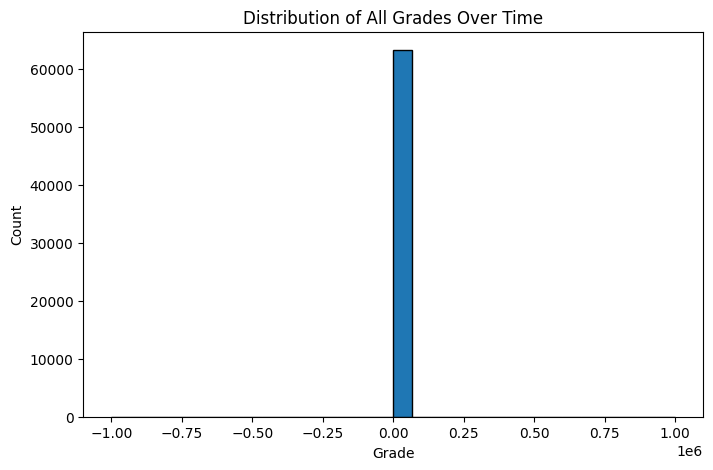

In [79]:
df["grade"] = pd.to_numeric(df["grade"], errors="coerce")

plt.figure(figsize=(8, 5))
plt.hist(df["grade"].dropna(), bins=30, edgecolor='black')
plt.xlabel("Grade")
plt.ylabel("Count")
plt.title("Distribution of All Grades Over Time")
plt.show()

**1.2.1b (1 pts)** /Discuss/: Do you notice anything?

The grades are supposed to be between 1.0 and 10.0, but here the plot extends from -1e6 to 1e6. This is probably due to NaN values in the dataset. Therefore, all grades appear grouped near 0, as one column/spike in the histogram.

**1.2.2 (2 pts)**: Please make sure the grades are between 1 and 10 and try again. Note: Any grades that are **not** in this range should be dropped.

In [80]:
df["grade"] = pd.to_numeric(df["grade"], errors="coerce")

# I saw some weird grades when exploring the data: there are some NaN, some negative or very high grades (100000.0)
weird_grades = df[
    df["grade"].isna() | 
    (df["grade"] < 1.0) |
    (df["grade"] > 10.0)
]
print(weird_grades[["student_id", "grade"]])

      student_id      grade
347     00000279        NaN
395     00000072        NaN
511     00000068 -1000000.0
710     00000016        NaN
1072    00000274        NaN
...          ...        ...
62859   00001554        NaN
63255   00001964        NaN
63320   00002103        NaN
63372   00001640        NaN
63510   00001969        NaN

[382 rows x 2 columns]


Here we see some NaN, and one -1000000.0. These extreme numbers could be there because, maybe the data entered was a raw strings like "None" (i saw some "None" in the dataset"), and when it was converted, it made this extreme value.

In [81]:
non_nan_weird = weird_grades.dropna(subset=["grade"])
print(non_nan_weird[["student_id", "grade"]])

      student_id      grade
511     00000068 -1000000.0
2522    00000005 -1000000.0
4679    00000124  1000000.0
4922    00000446  1000000.0
5553    00000216 -1000000.0
...          ...        ...
56604   00001571  1000000.0
56778   00001969  1000000.0
60767   00001721  1000000.0
61955   00001603 -1000000.0
62001   00001722  1000000.0

[64 rows x 2 columns]


For the plot, I will drop all these NaN values, and also drop these extreme numbers, as they could be just an error when entering the grade (or something else, like not present at the exam, or cheating).

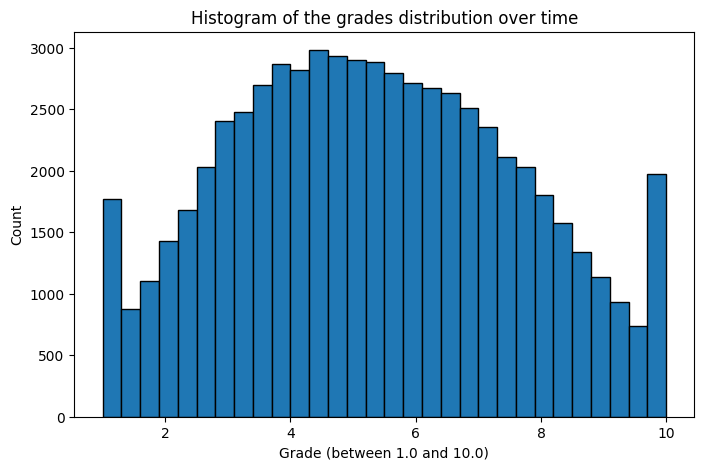

10.0 1.0


In [87]:
### YOUR CODE BELOW (THE **OUTPUT** OF THIS CELL WILL BE USED FOR EVALUATION) ###
df = df[(df["grade"] >= 1.0) & (df["grade"] <= 10.0)].copy() # The NaN will be dropped automatically

plt.figure(figsize=(8, 5))
plt.hist(df["grade"], bins=30, edgecolor='black')
plt.xlabel("Grade (between 1.0 and 10.0)")
plt.ylabel("Count")
plt.title("Histogram of the grades distribution over time")
plt.show()

### DO NOT MODIFY THE FOLLOWING LINES ###
# print the maximum and minimum grade after grade range conversion
print(df['grade'].max(), df['grade'].min())

## Task 2 (30 pts): Statistical Analysis

### Question 2.1 (6 pts)
Let's take a look at the grades over time. For this,
1. plot the average grades for each year/semester with 95% "standard error" confidence intervals (CI)
2. in the same figure, plot the average take-home and in-person grades with 95% CI


**More details about the plot**:

- The output should be a single plot with three colors (one each for "All", "Take-Home", and "In-Person" grades).  
- The plot should have 14 points on x-axis (or xticks), i.e., 7 years (2018-2024) and 2 semesters (Fall, Spring) per year in chronological order (e.g., `2018Fall`, `2018Spring`, `2019Fall`, ..., `2024Spring`).   
- The y-axis should represent the average grades for each semester.   
- You must also include error bars (it is recommended to use `plt.errorbar()` and `plt.fill_between()` functions) representing the 95% confidence intervals for the average grades.   
- Finally, in the figure, it is recommended that the x-axis label, y-axis label, and the title should be `Year and Semester`, `Average Grade` and `Average Grades Over Time by Exam Type`, respectively.

In [90]:
semester_order = {"Fall": 0, "Spring": 1}
df["sem_order"] = df["semester"].map(semester_order)
df["year_sem"] = df["year"].astype(str) + "_" + df["semester"]

def summarize(group):
    m = group["grade"].mean()
    se = group["grade"].std() / np.sqrt(len(group))
    ci = 1.96 * se   # for 95%
    return pd.Series({"mean": m, "ci": ci})

all_stats = df.groupby(["year", "sem_order", "year_sem"]).apply(summarize)   # All
th_stats = df[df["exam_type"] == "take-home"].groupby(
    ["year", "sem_order", "year_sem"]
).apply(summarize)   # Take-home
ip_stats = df[df["exam_type"] == "in-person"].groupby(
    ["year", "sem_order", "year_sem"]
).apply(summarize)   # In-person

all_stats = all_stats.sort_index(level=[0, 1])
th_stats  = th_stats.sort_index(level=[0, 1])
ip_stats  = ip_stats.sort_index(level=[0, 1])
x_labels = all_stats.index.get_level_values("year_sem")
x_positions = np.arange(len(x_labels))

C:\Users\msgar\AppData\Local\Temp\ipykernel_704\3974768746.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_stats = df.groupby(["year", "sem_order", "year_sem"]).apply(summarize)   # All
C:\Users\msgar\AppData\Local\Temp\ipykernel_704\3974768746.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(summarize)   # Take-home
C:\Users\msgar\AppData\Local\Temp\ipykernel_704\3974768746.py:17: FutureWarning:

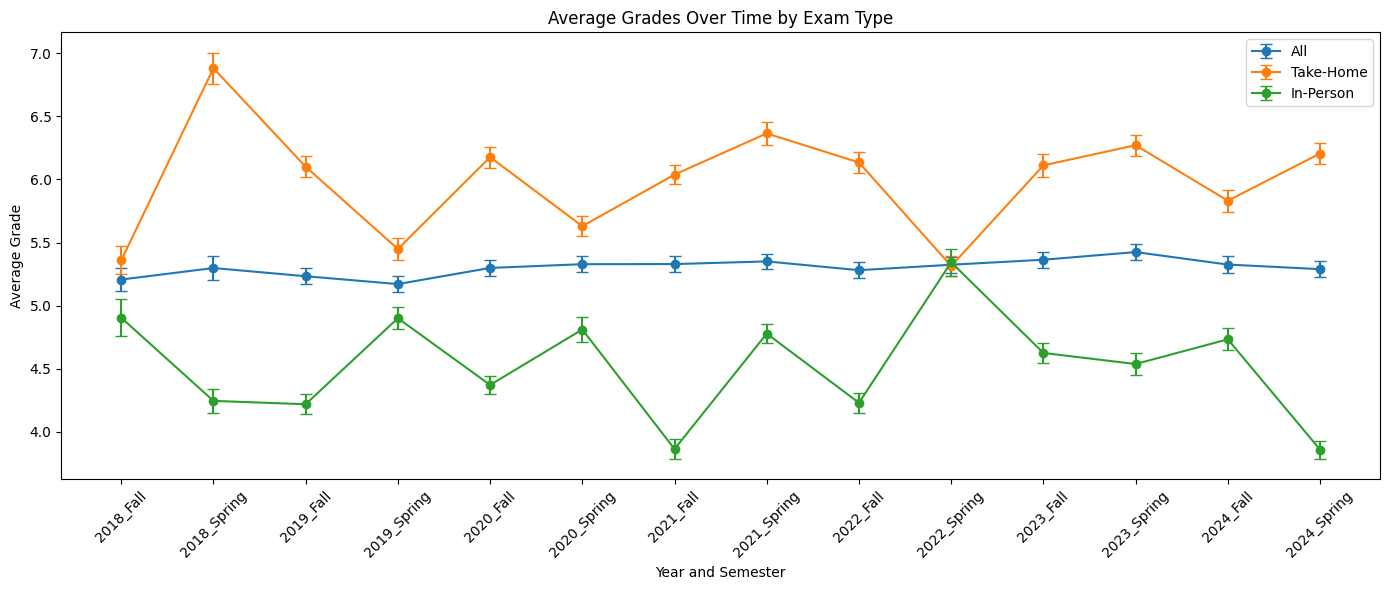

In [91]:
plt.figure(figsize=(14, 6))

plt.errorbar(
    x_positions, all_stats["mean"], yerr=all_stats["ci"],
    fmt="-o", capsize=4, label="All", color="tab:blue"
)
plt.errorbar(
    x_positions, th_stats["mean"], yerr=th_stats["ci"],
    fmt="-o", capsize=4, label="Take-Home", color="tab:orange"
)
plt.errorbar(
    x_positions, ip_stats["mean"], yerr=ip_stats["ci"],
    fmt="-o", capsize=4, label="In-Person", color="tab:green"
)

plt.xticks(x_positions, x_labels, rotation=45)
plt.xlabel("Year and Semester")
plt.ylabel("Average Grade")
plt.title("Average Grades Over Time by Exam Type")
plt.legend()
plt.tight_layout()
plt.show()


### Question 2.2 (6 pts)

The plots from the previous question suggest that grades for take-home exams are consistently higher than for in-person exams. This observation is the cornerstone of the cheating allegation.

**2.2.1 (4 pts)**: Perform an appropriate statistical test to determine if the overall difference in mean grades between take-home and in-person exams is statistically significant.

In [ ]:
### YOUR CODE BELOW (THE **OUTPUT** OF THIS CELL WILL BE USED FOR EVALUATION) ###
# compute p-value from t-test which will be used in the interpretation section below
p_value = None

### DO NOT MODIFY THE FOLLOWING LINES ###
# Interpretation
# we assume there the variable p_value from the t-test is defined above
alpha = 0.05
if p_value < alpha:
    print(f"\nThe p-value is less than {alpha}, so we reject the null hypothesis.")
    print("There is a statistically significant difference in grades between take-home and in-person exams.")
else:
    print(f"\nThe p-value is greater than {alpha}, so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in grades between take-home and in-person exams.")

**2.2.2 (1 pts)**: /Discuss/: Justify your choice of test.

In [ ]:
### YOUR ANSWER (CREATE A NEW MARKDOWN CELL BELOW TO ANSWER) ###

**2.2.3 (1 pts)**: /Discuss/: Based on the result, what would be your preliminary conclusion to Ms. Sakota?

In [ ]:
### YOUR ANSWER (CREATE A NEW MARKDOWN CELL BELOW TO ANSWER) ###

### Question 2.3 (8 pts)
A senior professor suggests that the university's admission standards have been getting tougher, leading to a stronger student body over the years. This could be a confounding factor. Let's rigorously test the theory that the student body's academic performance has been changing year-over-year. We can use clustering to identify performance groups for each year and track their proportions over time.

1. Create a feature set by calculating the average grade for each student for each year they were enrolled.

2. Using this yearly performance data, apply the k-means clustering algorithm with k=3 to group the student-year records.

3. Analyze the cluster centers to label the groups as 'Low', 'Medium', and 'High' performers for any given year. **Print out the cluster centers along with their corresponding (above) labels.**

4. **Create a stacked bar plot showing the proportion of students belonging to each performance tier for each year. Print out the proportions for each year as well.**

**Note**: It is recommended to have the plot title as `Student Performance Composition by Year`, x-axis label as `Year`, and y-axis label as `Proportion of Students`.

In [ ]:
from sklearn.cluster import KMeans

### (THE **OUTPUT** OF THIS CELL WILL BE USED FOR EVALUATION) ###

# Subtask 1. Create features: average grade per student, per year
# Create a feature set by calculating the average grade for each student for each year they were enrolled.

### YOUR CODE BELOW ###

# Subtask 2. Use k-means on the yearly average grade
# Using this yearly performance data, apply the k-means clustering algorithm with k=3 to group the student-year records.

### YOUR CODE BELOW ###

# Subtask 3. Analyze and label the clusters
# Analyze the cluster centers to label the groups as 'Low', 'Medium', and 'High' performers for any given year.
# Print out the cluster centers along with their corresponding (above) labels.

### YOUR CODE BELOW ###

# Subtask 4. Calculate proportions and create the stacked bar plot
# Create a stacked bar plot showing the proportion of students belonging to each performance tier for each year.
# Print out the proportions for each year as well.

### YOUR CODE BELOW ###

### Question 2.4 (5 pts)
The stacked bar plot from the previous question should suggest that the student body composition has been stable. While visual inspection is useful, a formal statistical test is more rigorous. Let's confirm if any apparent year-to-year change is statistically significant or likely due to random chance.

1. Focusing on the data for the last two years, 2023 and 2024, create a contingency table of student counts for each performance tier ('Low', 'Medium', 'High').

2. State the null (H0) and alternative (H1) hypotheses (in the markdown after this code cell) for a Chi-squared test of homogeneity on this data.

3. Perform the Chi-squared test. Report the Chi-squared statistic, the degrees of freedom, and the p-value.

4. Based on a significance level of α=0.05, what is your final conclusion?

**2.4.1 (4 pts)**: Code completion with conclusion about student body composition.

In [ ]:
from scipy.stats import chi2_contingency

### (THE **OUTPUT** OF THIS CELL WILL BE USED FOR EVALUATION) ###

# 1. Filter for the last two years and create a contingency table
# Focusing on the data for the last two years, 2023 and 2024, create a contingency table of student counts for each performance tier ('Low', 'Medium', 'High').

### YOUR CODE BELOW ###

# 3. Perform the Chi-squared test
# Perform the Chi-squared test. Report the Chi-squared statistic, the degrees of freedom, and the p-value.

### YOUR CODE BELOW ###

# 4. State the conclusion
# Based on a significance level of α=0.05, what is your final conclusion?
### YOUR CODE BELOW ###

**2.4.2 (1 pts)**: /Discuss/: State Hypotheses H0 and H1 you used for the Chi-squared test.

In [ ]:
### YOUR ANSWER (CREATE A NEW MARKDOWN CELL BELOW TO ANSWER) ###

### Question 2.5 (5 pts)

The analysis so far has looked at the changing student body as the primary explanation for the grade trends.
An alternative hypothesis is that the issue isn't the exam format itself, but the classes that use them. A reasonable way to define a class's difficulty is by the average grade it awards.

**2.5.1 (1 pts)**: Calculate the overall average grade for each unique class_id. Additionally, sort the class_id based on their average grades in ascending (increasing) order and print them which will be used for grading.

In [ ]:
### YOUR CODE BELOW (THE **OUTPUT** OF THIS CELL WILL BE USED FOR EVALUATION) ###

**2.5.2 (2 pts)**: Create a histogram of these average class grades to visualize the distribution of class difficulties.

In [ ]:
### YOUR CODE BELOW (THE **OUTPUT** OF THIS CELL WILL BE USED FOR EVALUATION) ###

**2.5.3a (1 pts)**: Based on your analysis, identify the top 5 "easiest" (highest average grade) and top 5 "hardest" (lowest average grade) classes.

In [ ]:
### YOUR CODE BELOW (THE **OUTPUT** OF THIS CELL WILL BE USED FOR EVALUATION) ###

**2.5.3b (1 pts)**: /Discuss/: What does the distribution tell you about the curriculum at St. Bob?

In [ ]:
### YOUR ANSWER BELOW (CREATE A NEW MARKDOWN CELL BELOW TO ANSWER) ###

## Task 3 (30 pts): Causal Analysis

In [ ]:
df_causal = pd.read_csv("data/grades_dataset_causal.csv")

### Question 3.1 (6 pts)

Our statistical analysis has revealed a complex web of relationships. A simple t-test is not enough to determine causation. To reason about this properly, we need to build a causal model.

**3.1.1 (2 pts)**: Draw a Directed Acyclic Graph (DAG) that illustrates the plausible causal relationships between the following four variables:

- Student Ability (a student's intrinsic academic skill)
- Class Difficulty (how easy or hard a class is)
- Exam Type (in-person or take-home)
- Grade (the final outcome)

**Note**: It is recommended to create a DAG as the answer to this question (since you will need it for answering next questions). However, for this question (3.1.1), no points will be deducted if you only provide the directed edges in text format.

In [ ]:
### YOUR ANSWER (CREATE A NEW MARKDOWN CELL BELOW TO ANSWER) ###
### YOU CAN ALSO USE PYTHON PACKAGES AND CODE TO ANSWER THIS ###

**3.1.2 (2 pts)**: /Discuss/: For each arrow (directed edge) in your graph, write a one-sentence justification for its existence and direction. For example, "An arrow from Student Ability to Grade represents that a student's ability directly affects the grade they receive."

In [ ]:
### YOUR ANSWER (CREATE A NEW MARKDOWN CELL BELOW TO ANSWER) ###

**3.1.3 (2 pts)**: /Discuss/: Based on your DAG, identify any confounding variables that might distort the simple relationship between Exam Type and Grade. Explain how your diagram illustrates this confounding.

In [ ]:
### YOUR ANSWER (CREATE A NEW MARKDOWN CELL BELOW TO ANSWER) ###

### Question 3.2 (5 pts)

Your DAG likely shows that a student's ability is a major confounder. We can control for this by comparing a student against themselves. A paired t-test is an excellent tool for this.

**3.2.1 (2 pts)**: 
1. Identify all students who have taken at least one of each exam type during their studies. 
2. For this subset of students, calculate each student's average grade on take-home exams and their average grade on in-person exams. 

Since for the paired t-test we require students who have an average grade for BOTH exam types, your task is to **print the number of students who have taken both exam types**, which will be used for grading.

In [ ]:
### YOUR CODE BELOW (THE **OUTPUT** OF THIS CELL WILL BE USED FOR EVALUATION) ###
# At the end, print the number of students who have taken both exam types

**3.2.2a (1 pts)**: Perform a paired t-test on these two sets of average grades and print the T-statistic and P-value. 

In [ ]:
### YOUR CODE BELOW (THE **OUTPUT** OF THIS CELL WILL BE USED FOR EVALUATION) ###

**3.2.2b (2 pts)**: /Discuss/: State your null and alternative hypotheses. 

In [ ]:
### YOUR ANSWER (CREATE A NEW MARKDOWN CELL BELOW TO ANSWER) ###

### Question 3.3 (6 pts)

The paired t-test in the previous question was a great step, as it controlled for baseline differences in Student Ability by comparing each student to themselves. However, there's another potential confounding factor we haven't addressed: Class Difficulty. What if students tend to get take-home exams in easier classes? If so, the higher grades might be due to the class being easy, not the exam type.

**3.3.1 (5 pts)**:
To isolate the true effect of the exam type, we need to make our comparisons even fairer by controlling for both student ability (you can ignore the "Medium" performers, and consider "High" as High-ability students and "Low" for Low-ability students)  and class difficulty at the same time.

1. Using the `df_causal` dataset, group your data into four distinct categories based on student ability and class difficulty:

- High-ability students in Easy classes
- Low-ability students in Easy classes
- High-ability students in Hard classes
- Low-ability students in Hard classes

2. Create a 1x2 grid of subplots to compare these groups.

- The left subplot should show the data for Easy classes and the right for Hard classes.
- On the x-axis of each subplot, show the results for 'Low' and 'High' ability students.
- Use bars to represent the average grade for both 'in-person' and 'take-home' exams within each category.

In [ ]:
### YOUR CODE BELOW (THE **OUTPUT** OF THIS CELL WILL BE USED FOR EVALUATION) ###

**3.3.2 (1 pts)** /Discuss/: Analyze your plot. After controlling for both factors, what is the difference in average grades between exam types within each of the four subgroups?

In [ ]:
### YOUR ANSWER (CREATE A NEW MARKDOWN CELL BELOW TO ANSWER) ###

### Question 3.4 (9 pts)

Another way to untangle these effects is to use a predictive model. A decision tree can show us which factors are most important for predicting a student's grade, which can help confirm our causal conclusion.

**3.4.1 (6 pts)**  

**3.4.1a**: Prepare your data: Create a dataset with Grade as the target variable. The features should be:

- A numerical feature for Student Ability (use each student's overall average grade).

- A numerical feature for Class Difficulty (use each class's overall average grade).

- A numerical feature for Exam Type (convert 'in-person' to 0 and 'take-home' to 1).

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

### YOUR CODE BELOW ###

**3.4.1b**: Train a DecisionTreeRegressor on this data. To keep the model easy to interpret, set the max_depth to 3. **Visualize the resulting tree** with `plot_tree`.

In [ ]:
### YOUR CODE BELOW (THE **OUTPUT** OF THIS CELL WILL BE USED FOR EVALUATION) ###

**3.4.2 (1 pts)**: Print the `feature_importances_` of the trained model in ascending (increasing) order.

In [2]:
### YOUR CODE BELOW (THE **OUTPUT** OF THIS CELL WILL BE USED FOR EVALUATION) ###

**3.4.3 (2 pts)**:
/Discuss:/ 
1. According to the model, which features are most important for predicting a grade? 
2. How does the importance of Exam Type compare to the others? 
3. How does this support your conclusion from the stratified analysis?

In [ ]:
### YOUR ANSWER (CREATE A NEW MARKDOWN CELL BELOW TO ANSWER) ###

### Question 3.5 (4 pts)
/Discuss/: This is the final step in your investigation for Ms. Sakota. What is your ultimate conclusion now? Does the exam type itself cause higher grades, or was the initial observation misleading due to confounding variables? Explain your reasoning.

In [ ]:
### YOUR ANSWER (CREATE A NEW MARKDOWN CELL BELOW TO ANSWER) ###

## Task 4 (10 pts): Finding Potential Cheaters

But wait..., there could be some students who might be mis-using take-home exams to cheat. We will compare the increase in the average grades of students who took both types of exams (in-person and take-home) in 2022 and 2023, since ChatGPT was released in late 2022.

In [ ]:
df_causal = pd.read_csv("data/grades_dataset_causal.csv")

**4.1 (6 pts)**
1. Identify all students who took both types of exams in both 2022 and 2023 in `df_causal`.
2. For each of these students, calculate their average grade for in-person exams and take-home exams for both years.
3. For each student, compute the change in their average take-home exam grades from 2022 to 2023. Similarly, we also compute the change for in-person grades. We name them as `delta_takehome` and `delta_inperson` respectively.
4. Find the difference between `delta_takehome` and `delta_inperson` for each student. We call it as `delta_diff`.
4. Find the mean and standard deviation of `delta_diff` across all identified students.
5. Select 'outliers' as those students whose `delta_diff` is more than 2 standard deviations above the mean. Print the student IDs of these outliers as a list.

**Note**: When you run the cell, ensure that it will output the list of student IDs flagged as potential cheaters, which will be used for grading.

In [ ]:
### YOUR CODE BELOW (THE **OUTPUT** OF THIS CELL WILL BE USED FOR EVALUATION) ###
# Ensure that this cell outputs the student IDs of the outliers as a list of integer IDs

**4.2.1 (2 pts)**:
- /Discuss/: Assume we consider the outlier students as potential cheaters. Why could this approach fail to identify cheaters? Suggest one problem with the above approach.

In [ ]:
### YOUR ANSWER HERE (CREATE A NEW MARKDOWN CELL BELOW TO ANSWER) ###

**4.2.2 (2 pts)**:
- /Discuss/: Suggest one improvement to make this approach more robust.

In [ ]:
### YOUR ANSWER HERE (CREATE A NEW MARKDOWN CELL BELOW TO ANSWER) ###